In [3]:
# Set up CUDA in OS
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import seaborn as sn 
import pandas as pd
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision import datasets, models, transforms
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import time
import copy

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Check version of Pytorch
print(torch. __version__)

2.1.0


In [5]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [6]:
# Find out if a GPU is available
use_cuda = torch.cuda.is_available()
use_cuda

False

In [36]:
# Set up path for data after downloading
train_images = "C:/Users/bengisubulur/Desktop/Food-Item-Detection.v1i.yolov7pytorch/train/images/"
train_labels = "C:/Users/bengisubulur/Desktop/Food-Item-Detection.v1i.yolov7pytorch/train/labels/"
test_images = "C:/Users/bengisubulur/Desktop/Food-Item-Detection.v1i.yolov7pytorch/test/images/"
test_labels = "C:/Users/bengisubulur/Desktop/Food-Item-Detection.v1i.yolov7pytorch/test/labels/"
valid_images = "C:/Users/bengisubulur/Desktop/Food-Item-Detection.v1i.yolov7pytorch/valid/images/"
valid_labels = "C:/Users/bengisubulur/Desktop/Food-Item-Detection.v1i.yolov7pytorch/valid/labels/"


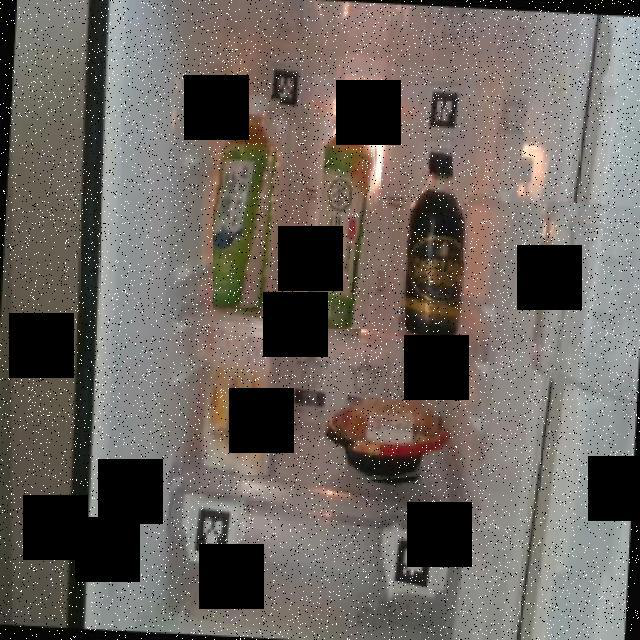

In [37]:


#Display image for reference 
from PIL import Image
im = Image.open(r"/Users/bengisubulur/Desktop/Food-Item-Detection.v1i.yolov7pytorch/train/images/001_png_jpg.rf.07d04531a296b96d3ffad3db54a54866.jpg")
width, height = im.size
im

In [39]:
label_file_path = "/Users/bengisubulur/Desktop/Food-Item-Detection.v1i.yolov7pytorch/train/labels/001_png_jpg.rf.07d04531a296b96d3ffad3db54a54866.txt"

with open(label_file_path, 'r') as file:
    lines = file.readlines()
 

In [40]:
class_id_list = []
center_x_list = []
center_y_list = []
label_width_list = []
label_height_list = []
left_multiplier_list = []
right_multiplier_list = []
top_multiplier_list = []
bottom_multiplier_list = []

In [41]:
#all the possible labels
names = ["Apple", 'Banana', 'Beans', 'Capsicum', 'Carrot', 'Cucumber', 'Curli-Flower', 'Orange', 'Tomato', 'Tomatos', 'apple', 'asparagus', 'avocado', 'banana', 'beef', 'bell_pepper', 'bento', 'blueberries', 'bottle', 'bread', 'broccoli', 'butter', 'can', 'carrot', 'cauliflower', 'cheese', 'chicken', 'chicken_breast', 'chocolate', 'coffee', 'corn', 'cucumber', 'egg', 'eggs', 'energy_drink', 'fish', 'flour', 'garlic', 'goat_cheese', 'grapes', 'grated_cheese', 'green_beans', 'ground_beef', 'guacamole', 'ham', 'heavy_cream', 'humus', 'juice', 'ketchup', 'kothmari', 'leek', 'lemon', 'lettuce', 'lime', 'mango', 'marmelade', 'mayonaise', 'milk', 'mushrooms', 'mustard', 'nuts', 'onion', 'orange', 'pak_choi', 'parsley', 'peach', 'pear', 'pineapple', 'plasticsaveholder', 'pot', 'potato', 'potatoes', 'pudding', 'red_cabbage', 'red_grapes', 'rice_ball', 'salad', 'sandwich', 'sausage', 'shrimp', 'smoothie', 'spinach', 'spring_onion', 'strawberries', 'sugar', 'sweet_potato', 'tea_a', 'tea_i', 'tomato', 'tomato_sauce', 'tortillas', 'turkey', 'watermelon', 'yogurt']
len(names)

94

In [42]:

for line in lines:
    parts = line.strip().split()  # Split the line into parts

    # characteristics of each of the labels
    class_id = int(parts[0])
    center_x = float(parts[1])
    center_y = float(parts[2])
    label_width = float(parts[3])
    label_height = float(parts[4])
    left_multiplier = center_x - (label_width / 2)
    right_multiplier = center_x + (label_width / 2)
    top_multiplier = center_y + (label_height / 2)
    bottom_multiplier = center_y - (label_height / 2)

 # Now I am adding each of these values to the lists I created
    class_id_list.append(class_id)
    center_x_list.append(center_x)
    center_y_list.append(center_y)
    label_width_list.append(label_width)
    label_height_list.append(label_height)
    left_multiplier_list.append(left_multiplier)
    right_multiplier_list.append(right_multiplier)
    top_multiplier_list.append(top_multiplier)
    bottom_multiplier_list.append(bottom_multiplier)
    
    
    print(f"Class ID: {class_id}, Center X: {center_x}, Center Y: {center_y}, Width: {label_width}, Height: {label_height}")


    # In these lines I am multiplying the Yolo float values which are between 0 and 1 by the width and height of the original picture so that I get the locations of the pixels.
    print("This is a " + str(names[class_id]))
    left_bound = round(left_multiplier * width)
    print("The left bound is " + str(left_bound))
    right_bound = round(right_multiplier * width)
    print("The right bound is " + str(right_bound))
    top_bound = round(bottom_multiplier * height)
    print("The top bound is " + str(top_bound))
    bottom_bound = round(top_multiplier * height)
    print("The bottom bound is " + str(bottom_bound))

Class ID: 86, Center X: 0.3859375, Center Y: 0.3171875, Width: 0.10625, Height: 0.340625
This is a tea_a
The left bound is 213
The right bound is 281
The top bound is 94
The bottom bound is 312
Class ID: 77, Center X: 0.3640625, Center Y: 0.62265625, Width: 0.13125, Height: 0.240625
This is a sandwich
The left bound is 191
The right bound is 275
The top bound is 322
The bottom bound is 476
Class ID: 87, Center X: 0.5359375, Center Y: 0.3234375, Width: 0.109375, Height: 0.38125
This is a tea_i
The left bound is 308
The right bound is 378
The top bound is 85
The bottom bound is 329
Class ID: 29, Center X: 0.67578125, Center Y: 0.3765625, Width: 0.1109375, Height: 0.30625
This is a coffee
The left bound is 397
The right bound is 468
The top bound is 143
The bottom bound is 339
Class ID: 16, Center X: 0.60546875, Center Y: 0.69140625, Width: 0.2046875, Height: 0.134375
This is a bento
The left bound is 322
The right bound is 453
The top bound is 400
The bottom bound is 486


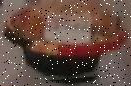

In [43]:
#original image
im1 = im.crop((left_bound, top_bound, right_bound, bottom_bound))
im1

In [44]:
#putting all the images together with the corresponding labels!


#crop every image so that we have only one label per image, save the cropped images in another file, train from that file

In [45]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=12, shuffle=True, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=12, shuffle=False, num_workers=0)
validate_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=12, shuffle=False, num_workers=0)

NameError: name 'train_dataset' is not defined

In [ ]:
#looking at our current data
print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))
print('Validate dataset size:', len(valid_data))
class_names = train_dataset.classes
print('Class names:', class_names)

In [ ]:
#getting the model
model = models.resnet18(pretrained=True)
model

In [ ]:
num_features = model.fc.in_features 
print('Number of features from pre-trained model', num_features)

In [ ]:
# Add a fully-connected layer for classification, we have 94 classes in total
model.fc = nn.Linear(num_features, 94)
model = model.to(device)

In [ ]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [ ]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [ ]:
#### Train model
train_loss=[]
train_accuary=[]
test_loss=[]
test_accuary=[]

num_epochs = 30   #(set no of epochs)
start_time = time.time() #(for showing time)
# Start loop
for epoch in range(num_epochs): #(loop for every epoch)
    print("Epoch {} running".format(epoch)) #(printing message)
    """ Training Phase """
    model.train()    #(training model)
    running_loss = 0.   #(set loss 0)
    running_corrects = 0 
    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device) 
        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        # get loss value and update the network weights
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data).item()
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    # Append result
    train_loss.append(epoch_loss)
    train_accuary.append(epoch_acc)
    # Print progress
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time() -start_time))
    """ Testing Phase """
    model.eval()
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data).item()
        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects / len(test_dataset) * 100.
        # Append result
        test_loss.append(epoch_loss)
        test_accuary.append(epoch_acc)
        # Print progress
        print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time()- start_time))